# <span style='color:orange'> Test Performance of BRATS Model on Synthesized T2FLAIR Modality using T1 and T2 Sequences</span>

In [1]:
import h5py
import sys
sys.path.append('..')
from modules.configfile import config
import matplotlib.pyplot as plt
import cPickle as pickle
import numpy as np
import random
from random import shuffle
random.seed(1337)
np.random.seed(1337)
from modules.training_helpers import standardize
from modules.vizhelpercode import viewArbitraryVolume

# Threshold to use when converting prediction mask to binary
THRESHOLD = 0.5


/home/anmol/.virtualenvs/brats/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# <span style='color:teal'> Helper Functions </span>

# Function to load BRATS model for segmentation of the test_data patients

In [2]:
def getBRATSModel():
    import os
    os.environ["KERAS_BACKEND"] = "tensorflow"
    from modules.training_helpers import standardize
    from modules.vizhelpercode import viewArbitraryVolume
    import importlib
    
    defmodelfile = 'isensee'
    
    model_name = '/home/anmol/mounts/cedar-rm/scratch/asa224/model-staging/isensee_da_noanneal64--0.64.h5'
    
    modeldefmodule = importlib.import_module('defmodel.' + defmodelfile, package=None)
    custom_objs = modeldefmodule.custom_loss()
    
    model = modeldefmodule.open_model_with_hyper_and_history(name=model_name, custom_obj=custom_objs, load_model_only=True)
    
    return model

### This function is for the phase where new prediction has to be performed using BRATS model, on a patient who's one or more modalities are synthesized

In [3]:
def predictOnSynthesisExample(test_arr, model):
    td_shape = test_arr.shape
    
    pat_volume = np.array(test_arr, copy=True)
    print('Standardizing..')
    pat_volume = standardize(pat_volume, applyToTest=mean_var)

    curr_shape = list(pat_volume.shape)
    curr_shape.insert(0, 1) # insert 1 at index 0 to make reshaping easy

    pat_volume = pat_volume.reshape(curr_shape)

    # SUPER HACK WAY TO CHANGE VOLUME COMPATIBILITY WITH ISENSEE MODEL. MAKE 155 = 160
    new_pat_volume = np.zeros((1, 4, 240, 240, 160))
    new_pat_volume[:, :, :, :, 0:155] = pat_volume

    print('Starting prediction..')
    # predict using the whole volume
    pred = model.predict(new_pat_volume)
    
    # get back the main volume and strip the padding
    pred = pred[:,:,:,:,0:155]

    assert pred.shape == (1,3,240,240,155)
    
    return pred

### Define Dice Coefficient in Numpy

In [4]:
def dice(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

### Helper functions to get the exact modalities according to the loaded synthesis model

In [46]:
def returnID(mod):
    '''
    if 't1.' 
        i = 0
        seq_name = 't1'
    elif 't2.' in imagefile:
        i = 1
        seq_name = 't2'
    elif 't1ce.' in imagefile:
        i = 2
        seq_name = 't1ce'
    elif 'flair.' in imagefile:
        i = 3
        seq_name = 'flair'
    '''
    if mod.lower() == 't1':
        return 0
    elif mod.lower() == 't2':
        return 1
    elif mod.lower() == 't1ce':
        return 2
    elif mod.lower() == 't2flair':
        return 3
    
        
def returnIDGeneric(mod):
    if not type(mod) == list:
        return returnID(mod)
    else:
        k = []
        for mod_name in mod:
            t = returnID(mod_name)
            k.append(t)
            print('i = {} for modality = {}'.format(t, mod_name))
        return k
            
    
def multiSwap(arr):
    '''
    Expects a single channel array of shape (240, 240, 155)
    
    Returns: Array of shape (155, 1, 240, 240)
    '''
    arr = np.swapaxes(arr, 2, 1)
    arr = np.swapaxes(arr, 1, 0)
    arr = arr.reshape(155,1,240,240)
    return arr

def invertShape(arr):
    '''
    Expects a single channel array of shape (155, 1, 240, 240)
    
    Returns: Array of shape (1, 240, 240, 155)
    '''
    # squeeze out the 1 from axis=1
    arr = np.squeeze(arr, axis=1)
    
    arr = np.swapaxes(arr, 0, 1)
    arr = np.swapaxes(arr, 1, 2)
    arr = arr.reshape(1, 240, 240, 155)
    return arr

def apply_mean_std(im, mean_var):
    # expects a dictionary of means and VARIANCES, NOT STD
    for m in range(0,4):
        if len(np.shape(m)) > 4:
            im[:,m,...] = (im[:,m,...] - mean_var['mn'][m]) / np.sqrt(mean_var['var'][m])
        else:
            im[m,...] = (im[m,...] - mean_var['mn'][m]) / np.sqrt(mean_var['var'][m])
            
    return im

def getChannelWiseMasks(segmasks):
    y_batch_channel_wise = np.zeros((segmasks.shape[0], config['num_labels'],
                                                 segmasks.shape[1], segmasks.shape[2], segmasks.shape[3]))

    labels = [1,2,4]

    # save individual masks
    # 1 = necrotic + non-enhancing
    # 2 = edema
    # 4 = enhancing

    for idx, i in enumerate(labels):
        # inside the channel 'i' in y_batch_channel_wise, set all voxels which have label 'i' equal to 'i'.
        # in the zeroth channel, find the voxels which are 1, and set all those corresponding voxels as 1
        # there's no seperate  channel  for background class.
        y_batch_channel_wise[:, idx, ...][np.where(segmasks == i)] = 1
        
    return y_batch_channel_wise

def getBRATSBenchmarkMasks(segmasks, ground_truth=True):
    y_batch_channel_wise = np.zeros((segmasks.shape[0], config['num_labels'],
                                                 segmasks.shape[2], segmasks.shape[3], segmasks.shape[4]))

    labels = [1,2,4]
    
    # create a copy to avoid in place changes
    segmasks_temp = np.array(segmasks, copy=True)
    
    # save individual masks
    # 1 = necrotic + non-enhancing
    # 2 = edema
    # 4 = enhancing
    if ground_truth == False:
        # threshold the masks
        segmasks_temp = segmasks_temp > THRESHOLD

        # convert to binary mask with 0 and 1
        segmasks_temp = segmasks_temp.astype(np.uint16)
        

    whole_tumor_mask = segmasks_temp[:,0] + \
                segmasks_temp[:,1] + \
                segmasks_temp[:,2]

    tumor_core_mask = segmasks_temp[:,0] + \
                    segmasks_temp[:,2]

    enhancing_mask = segmasks_temp[:,2]
    
    y_batch_channel_wise[:,0] = whole_tumor_mask
    y_batch_channel_wise[:,1] = tumor_core_mask
    y_batch_channel_wise[:,2] = enhancing_mask

    return y_batch_channel_wise

## Open mean and variance file

In [6]:
mean_var = pickle.load(open(config['saveMeanVarCombinedData'], 'rb'))

In [7]:
mean_var

{'mn': [101.05125, 104.49648, 111.35362, 70.27612],
 'var': [299264.5, 362103.22, 317921.5, 319424.38]}

## Open new database with cropped images

In [8]:
hdf5_file = h5py.File(config['hdf5_combined'], mode='r')

In [9]:
hdf5_file_g = hdf5_file['combined']

In [10]:
hdf5_file_g['training_data'].shape

(285, 4, 240, 240, 155)

## Generate random access order

In [11]:
indices = list(range(0, hdf5_file_g['training_data'].shape[0]))
shuffle(indices)

## Split indices into training and testing

In [12]:
train_end = int((len(indices) * config['data_split']['train']) / 100.0)
train_indices = indices[0:train_end]
test_indices = indices[train_end:]

In [13]:
train_indices[0:5]

[277, 67, 207, 140, 148]

#### In the train_seg.py, this is the original indices:

[255, 219, 107, 230, 46, 165, 103, 151, 176]

In [14]:
test_indices

[255, 219, 107, 230, 46, 165, 103, 151, 176]

# Create a test set which is independent of any patient that was used in multimodal-synthesis model training as well as for BRATS model

The multimodal-synthesis model was trained with indices 0-54 from the Combined HDF5 file. Do not use any data from this range as your test data. 

In [15]:
new_test_ind = [x for x in test_indices if x > 54]

In [16]:
new_test_ind

[255, 219, 107, 230, 165, 103, 151, 176]

### test_data contains the test set which neither multimodal-synthesis model not BRATS model has seen. So it will be a fair comparison

In [17]:
test_data = hdf5_file_g['training_data'][sorted(new_test_ind)]
test_data_masks = hdf5_file_g['training_data_segmasks'][sorted(new_test_ind)]

In [18]:
test_data.shape

(8, 4, 240, 240, 155)

In [19]:
test_data_masks.shape

(8, 240, 240, 155)

### Get channel wise masks for calculation of dice coefficient

In [20]:
test_data_masks_channel_wise = getChannelWiseMasks(test_data_masks)

In [21]:
test_data_masks_channel_wise.shape

(8, 3, 240, 240, 155)

# <span style='color:blue'> Predict Segmentation Mask using BRATS Model using ALL ORIGINAL Available Modalities</span>

## Start the prediction process

In [ ]:
model = getBRATSModel()

In [ ]:
td_shape = test_data.shape
test_data_pred = np.zeros((td_shape[0], 3, td_shape[2], td_shape[3], td_shape[4]))

for i in range(0, test_data.shape[0]):
    print('Patient {}'.format(i+1))
    pat_volume = test_data[i]
    print('Standardizing..')
    pat_volume = standardize(pat_volume, applyToTest=mean_var)

    curr_shape = list(pat_volume.shape)
    curr_shape.insert(0, 1) # insert 1 at index 0 to make reshaping easy

    pat_volume = pat_volume.reshape(curr_shape)

    # SUPER HACK WAY TO CHANGE VOLUME COMPATIBILITY WITH ISENSEE MODEL. MAKE 155 = 160
    new_pat_volume = np.zeros((1, 4, 240, 240, 160))
    new_pat_volume[:, :, :, :, 0:155] = pat_volume

    print('Starting prediction..')
    # predict using the whole volume
    pred = model.predict(new_pat_volume)

    # get back the main volume and strip the padding
    pred = pred[:,:,:,:,0:155]

    assert pred.shape == (1,3,240,240,155)

    print('Adding predicted volume to test_data_pred store..')
    # we use the batch size = 1 for prediction, so the first one.
    test_data_pred[i] = pred[0]
    viewArbitraryVolume(test_data_pred[i], slice_idx=3)

### Create masks according to BRATS benchmark

1) the “whole” tumor region (including all four tumor struc- tures),
2) the tumor “core” region (including all tumor structures ex- cept “edema”),
3) and the “active” tumor region (only containing the “en- hancing core” structures that are unique to high-grade cases).

In [ ]:
test_data_masks_channel_wise.shape

In [ ]:
test_data_pred_BRATS = getBRATSBenchmarkMasks(test_data_pred, ground_truth=False)
test_data_masks_channel_wise_BRATS = getBRATSBenchmarkMasks(test_data_masks_channel_wise, ground_truth=True)

In [ ]:
viewArbitraryVolume(test_data_pred_BRATS[4], slice_idx=3)

In [ ]:
new_test_ind

## Calculate Dice Coeffcient for this original predictions against the masks

In [ ]:
results_BRATS_original = {}
dice_scores = {
    'whole_tumor': 0,
    'tumor_core': 1,
    'enhancing': 2,
    }

for i, patid in enumerate(new_test_ind):
    results_BRATS_original[str(patid)] = {}

    for key, val in dice_scores.items():
        # idx = 1 whole tumor
        # idx = 2 tumor core
        # idx = 3 enhancing

        value = dice(test_data_pred_BRATS[i,val], test_data_masks_channel_wise_BRATS[i,val])
        results_BRATS_original[str(patid)][key] = value

In [ ]:
results_BRATS_original

### Save test_data_pred numpy array

This is the original set of predictions for 8 test patients using vanilla BRATS model and all ORIGINAL modalities in BRATS validation format (WT, TC, EN)

In [ ]:
np.save(open('/home/anmol/mounts/cedar-rm/scratch/asa224/misc/ORIGINAL_PREDICTIONS.npz', 'wb'), test_data_pred_BRATS)

In [ ]:
np.save(open('/home/anmol/mounts/cedar-rm/scratch/asa224/misc/TEST_GROUND_TRUTH.npz', 'wb'), test_data_masks_channel_wise_BRATS)

# <span style='color:green'> Synthesize T2FLAIR Modality using T1 and T2 Modalities and a Pretrained Multimodal-Synthesis Model</span>

# Load multimodal-synthesis model trained with T1-T2 as input and T2FLAIR as output

In [22]:
import os
os.environ["KERAS_BACKEND"] = "theano"

In [23]:
from multimodal.loader_multimodal import Data
from multimodal.runner import Experiment
from multimodal.model import Multimodel

Using Theano backend.
../multimodal/model.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/anmol/.virtualenvs/brats/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/anmol/.virtualenvs/brats/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/anmol/.virtualenvs/brats/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_l

# Load the model and set it up

In [24]:
# what modalities to finally load from the bigger model. Used in both model loading and data loading
load_input_modalities = ['T1', 'T2']
load_output_modalities = 'T2FLAIR'

In [25]:
print('Loading partial model')

# =================================================================
'''
For more info, refer to runner.py and model.py
'''
# =================================================================
orig_input_modalities = ['T1', 'T2']
orig_output_weights = {'T2FLAIR': 1.0, 'concat': 1.0}
orig_output_modalities = sorted([o for o in orig_output_weights if o != 'concat'])
latent_dim = 16
spatial_transformer = False
common_merge = 'max'
ind_outs = True
fuse_outs = True
model_path = '/home/anmol/mounts/cedar-rm/rrg_proj_dir/multimodal_brain_synthesis/RESULTS/split57_no_ST_LGG_only_T1_T2-T2FLAIR/'
model_name = 'model'
# =================================================================

print('Creating experiment...')

def create_model():
    print('Creating model...')
    chn = 1
    print 'Channels: %d' % chn
    mm = Multimodel(orig_input_modalities, orig_output_modalities, orig_output_weights, latent_dim, chn,
                         spatial_transformer, common_merge, ind_outs, fuse_outs)
    mm.build()
    return mm

# create the base model with all inputs/outputs
mm = create_model()

# load the weights
mm.model.load_weights(os.path.join(model_path, model_name))

# slice the model and get only the inputs/outputs we want.
mm.model = mm.get_partial_model(load_input_modalities, load_output_modalities)

Loading partial model
Creating experiment...
Creating model...
Channels: 1
Latent dimensions: 16


../multimodal/model.py:79: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  skip = merge([act2, conv], mode='concat', concat_axis=1, name='enc_' + modality + '_skip1')
/home/anmol/.virtualenvs/brats/local/lib/python2.7/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
../multimodal/model.py:88: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  skip = merge([act1, conv], mode='concat', concat_axis=1, name='enc_' + modality + '_skip2')


Fuse latent representations using max


../multimodal/model.py:206: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  weighted_rep = merge(ind_emb, mode=cm, name='combined_em') if len(self.inputs) > 1 else ind_emb[0]
../multimodal/model.py:104: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  skip = merge([inp, conv], mode='concat', concat_axis=1, name='dec_' + modality + '_skip1')
../multimodal/model.py:107: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  skip = merge([skip, conv], mode='concat', concat_axis=1, name='dec_' + modality + '_skip2')
../multimodal/model.py:109: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Elemwise{m..., name="decoder_T2FLAIR", input

making output: TensorType(float32, 4D) TensorType(float32, 4D) em_0_dec_T2FLAIR
making output: TensorType(float32, 4D) TensorType(float32, 4D) em_1_dec_T2FLAIR
making output: TensorType(float32, 4D) TensorType(float32, 4D) em_2_dec_T2FLAIR
making output: em_concat TensorType(float32, 3D) em_concat
all outputs:  ['em_0_dec_T2FLAIR', 'em_1_dec_T2FLAIR', 'em_2_dec_T2FLAIR', 'em_concat', 'em_fused']
output dict:  {'em_concat': <function embedding_distance at 0x7fa418b12b90>, 'em_1_dec_T2FLAIR': <function mae at 0x7fa418b12c80>, 'em_2_dec_T2FLAIR': <function mae at 0x7fa418b12c80>, 'em_fused': <function embedding_distance at 0x7fa418b12b90>, 'em_0_dec_T2FLAIR': <function mae at 0x7fa418b12c80>}
loss weights:  {'em_concat': 1.0, 'em_1_dec_T2FLAIR': 1.0, 'em_2_dec_T2FLAIR': 1.0, 'em_fused': 0.0, 'em_0_dec_T2FLAIR': 1.0}
making output: TensorType(float32, 4D) TensorType(float32, 4D) em_0_dec_T2FLAIR
making output: TensorType(float32, 4D) TensorType(float32, 4D) em_1_dec_T2FLAIR
making output: 

../multimodal/model.py:328: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[em_0_dec_..., inputs=[/enc_T1_i...)`
  model = Model(input=inputs, output=outputs)


# Load the data according to how multimodel expects it

### Load each test patient, and predict the modality 

In [47]:
print('Loading data...')
td_shape = test_data.shape

# create a major numpy array to hold all synthesized T2FLAIR volumes
# shape = (8, 1, 240, 240, 155)
preds = np.zeros((td_shape[0], 1, td_shape[2], td_shape[3], td_shape[4]))

for k in range(test_data.shape[0]): # for each patient
    print('Patient {}'.format(k+1))
    
    pat_volume = test_data[k]
    # DO NOT STANDARDIZE, the Multimodal-synthesis model doesnt expect standardized volumes
    print('Setting data up for prediction...')
    temp = [multiSwap(pat_volume[i]) for i in returnIDGeneric(load_input_modalities)] # seprate out the channels
    
    print('Starting prediction process')
    pred_temp = mm.model.predict(temp)
    print('Prediction process finished!')
    
    print('Saving the synthesized T2FLAIR volume using both T1 and T2')
    preds[k,] = invertShape(pred_temp[-1])

Loading data...
Patient 1
Setting data up for prediction...
i = 0 for modality = T1
i = 1 for modality = T2
Starting prediction process
Prediction process finished!
Saving the synthesized T2FLAIR volume using both T1 and T2
Patient 2
Setting data up for prediction...
i = 0 for modality = T1
i = 1 for modality = T2
Starting prediction process
Prediction process finished!
Saving the synthesized T2FLAIR volume using both T1 and T2
Patient 3
Setting data up for prediction...
i = 0 for modality = T1
i = 1 for modality = T2
Starting prediction process
Prediction process finished!
Saving the synthesized T2FLAIR volume using both T1 and T2
Patient 4
Setting data up for prediction...
i = 0 for modality = T1
i = 1 for modality = T2
Starting prediction process
Prediction process finished!
Saving the synthesized T2FLAIR volume using both T1 and T2
Patient 5
Setting data up for prediction...
i = 0 for modality = T1
i = 1 for modality = T2
Starting prediction process
Prediction process finished!
Sav

In [48]:
# save the synthesized T2FLAIR modalities in the misc folder.
np.save(open('/home/anmol/mounts/cedar-rm/scratch/asa224/misc/SYNTHESIZED_T2FLAIR.p', 'wb'), preds)

### Helper function to view synthesized data

In [ ]:
preds

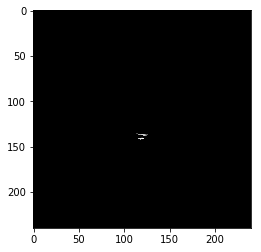

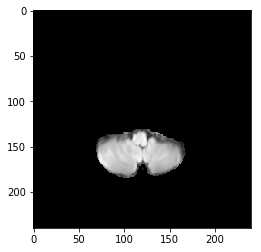

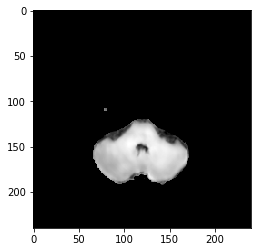

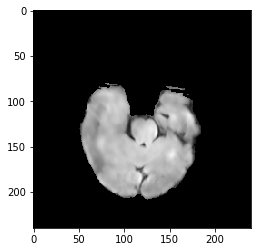

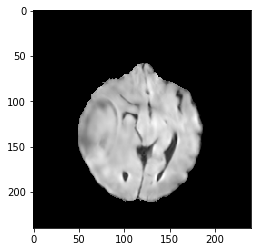

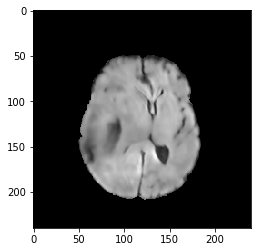

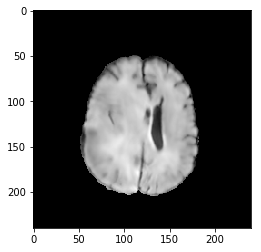

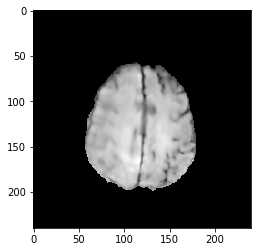

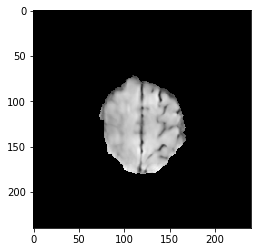

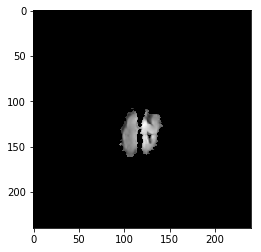

In [53]:
for i in range(0, 150, 15):
    plt.imshow(preds[1,0,:,:,i], cmap='gray')
    plt.show()

In [ ]:
test_vol = test_data[0]
gt_flair = test_vol[3,]
pred = preds[2]

# swap the axes of gt_flair to match the shape of prediction
gt_flair = multiSwap(gt_flair)

# remove the dummy axis 1 from both arrays
pred_final = np.squeeze(pred, axis=1)
gt_flair_final = np.squeeze(gt_flair, axis=1)

In [ ]:
viewCurrentVolume(pred_final)

In [ ]:
viewCurrentVolume(gt_flair_final)

# <span style='color:red'> Test Performance of BRATS Model on Synthesized T2FLAIR Modality using T1 and T2 Sequences</span>


#### Switch all original T2FLAIR modalities from all patients to the ones that were synthesized

In [ ]:
# open the original predictions

# get the original test data

# get the synthesized t2flair volumes

# create copy of test data for future

# set t2flair volumes in the copy of test_data to the synthesized versions

# confirm shapes are correct for the BRATS model

# perform prediction using BRATS model

# save predictions in NPZ files

# calculate dice coefficient on the predicted segmentation masks and ground truth, using 
# BRATS notation (WT, ENH, TC)

# Create another test_vol with FLAIR replaced with the synthesized and NON-standardized version

Standardization of the test volume will be done right before prediction

In [ ]:
pred_final_orignal_shape

In [ ]:
test_vol_new = np.array(test_vol, copy=True)

In [ ]:
test_vol_new[returnIDGeneric('t2flair'),...] = pred_final_orignal_shape

In [ ]:
brats_model = getBRATSModel()

In [ ]:
brats_model.summary()

In [ ]:
test_vol_new.shape

In [ ]:
pred = predictOnSynthesisExample(test_vol_new, brats_model)

In [ ]:
# get back the main volume and strip the padding
pred = pred[:,:,:,:,0:155]

In [ ]:
pred.shape

In [ ]:
viewArbitraryVolume(pred[0], slice_idx=3)